In [1]:
import os,sys, re, time
from importlib import reload
import numpy as np
import pandas as pd

#import torch
print(os.getpid())
sys.path.append(r'C:\Softwares\Github\MerScope01')

71084


In [2]:
import cv2
from ChromAn.src.file_io.data_organization import search_fovs_in_folders, Color_Usage
from ChromAn.src.segmentation_tools.cells import Align_Segmentation

In [3]:
import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from copy import copy

In [4]:
# Cellpose 
from cellpose import models

## Folders

In [5]:
# data_folder
data_folder = r'\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s'
# correction
correction_folder = r'\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\Corrections\20210621-STORM6_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    print(segmentation_save_folder)
    os.makedirs(segmentation_save_folder)
watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

In [6]:
# transpose with microscope
microscope_file = r'\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\Softwares\Weissman_MERFISH_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [7]:
# search folders
folders, fovs = search_fovs_in_folders(data_folder)
# Color usage file marks the organization of imaging files
color_usage_filename = r'\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Analysis\Color_Usage.csv'
color_usage_df = Color_Usage(color_usage_filename)

- searching in folder: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s
-- 20 folders, 173 fovs detected.
- load color_usage from file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Analysis\Color_Usage.csv


In [8]:
# from color_usage, find dapi / polyt / fiducial
dapi_info = color_usage_df.get_dapi_info()[0]
polyt_info = color_usage_df.get_polyt_info()[0]
fiducial_channel = color_usage_df.get_fiducial_channel(color_usage_df)
print(dapi_info, polyt_info, fiducial_channel)

{'hyb': 'H0M1', 'channel': '405'} {'channel': '647', 'hyb': 'H19R1'} 488


# Run segmentation

In [9]:

from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d

In [10]:

for _fov_id, _fov_name in enumerate(fovs):

    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        batch_size=60, #anisotropy=250/108,
                                        anisotropy=1000/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=60, 
                                        min_size=2000,
                                        do_3D=True,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = labels3d.copy() # no modification is required for this one.

        # save this segmentation mask
        print(f"- save to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )

Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_0.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_1.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_2.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_3.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_4.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_l

- apply microscope corrections
- run Cellpose segmentation in 142.370s.
- save to file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_20.npy


<IPython.core.display.Javascript object>


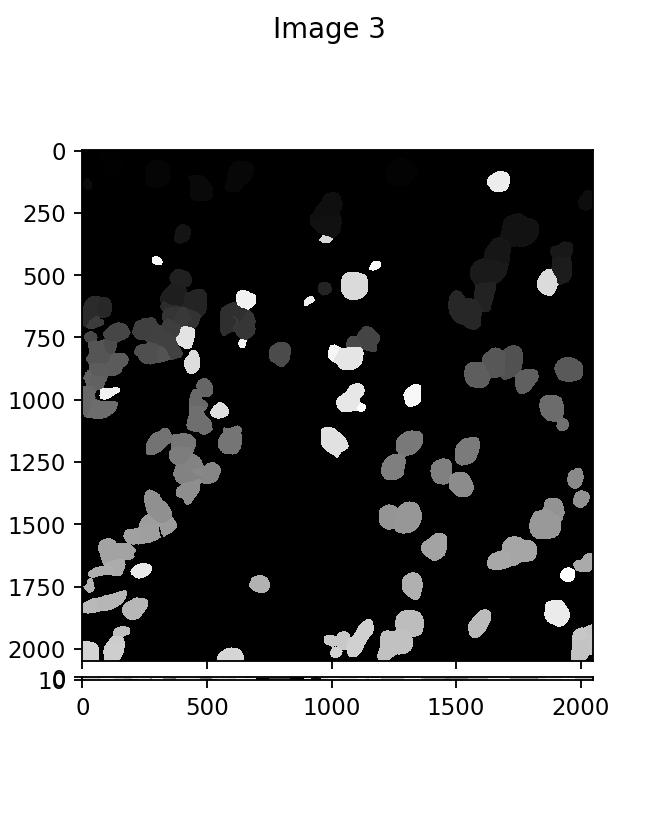

In [24]:
%matplotlib notebook
imshow_mark_3d([polyt_im, dapi_im, corr_labels3d])

# STEP2: Watershed: Optional, potentially make it worse

In [11]:
watershed_th = 1.6

for _fov_id, _fov_name in enumerate(fovs):
    

    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    
    
    _save_id = _fov_id 

    dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, watershed_th)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    #np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    break

- directly load seg from: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_0.npy
reference image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
PolyT and DAPI image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H19R1\Conv_zscan_000.dax
Initialize DaxProcesser for file:\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
- New save file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488', '405'] in 1.732s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:[

<IPython.core.display.Javascript object>


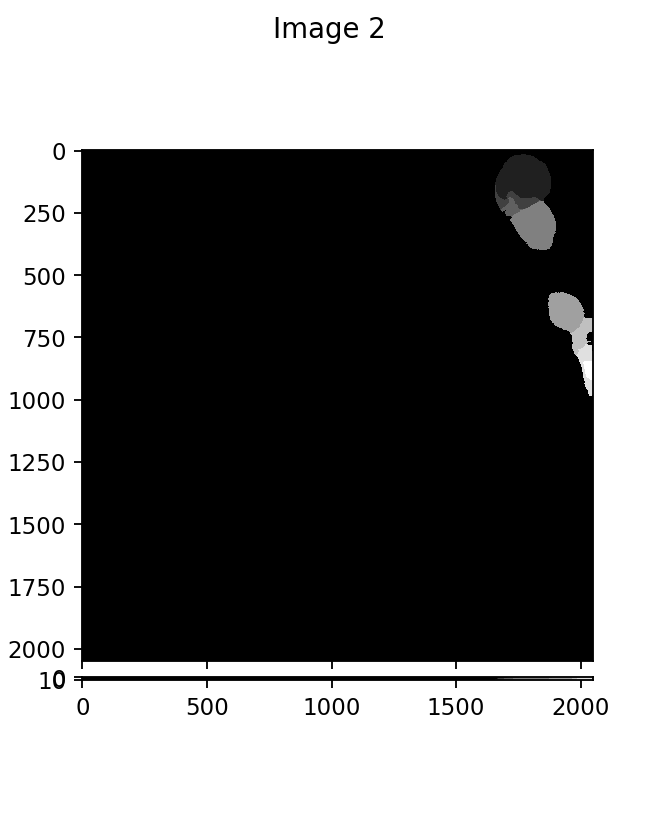

In [203]:
imshow_mark_3d([new_labels, corr_labels3d])

## visualize merlin_output_tif

In [12]:
import tifffile
ims = tifffile.imread(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\images\aligned_fiducial_images30.tif')